In [31]:
import copy
from collections import defaultdict
import itertools
import math
from pathlib import Path
from typing import List, Optional, Dict, Any, Callable
import types

from bella.data_types import TargetCollection, Target
from bella import lexicons
from bella import tokenisers
from bella.dependency_parsers import stanford, tweebo
from bella.word_vectors import GloveCommonCrawl, SSWE
from bella.models.target import TargetInd, TargetDepMinus
from bella.models.target import TargetDep, TargetDepPlus
from bella.models.tdparse import TDParseMinus, TDParse
from bella.models.tdparse import TDParsePlus
from bella.models.base import SKLearnModel
from bella import parsers
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

import config
import thesis_statistics as thesis_stats

matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")


In [235]:
def param_string(param_value: Any) -> str:
    '''
    Given any type of value will convert it into a 
    String.
    
    The main difference between this and the function 
    :py:func:`str` is that this handles case such as 
    functions where the `name` attribute is used instead.
    
    :param param_value: Any type of argument.
    :returns: Meaningful String for the given argument
    '''
    if isinstance(param_value, lexicons.Lexicon):
        return param_value.name
    elif isinstance(param_value, types.FunctionType):
        return param_value.__name__
    else:
        return str(param_value)

def default_params(datasets: List[TargetCollection], 
                   model_names: List[str], 
                   specific_params: Optional[Dict[str, Dict[str, Dict[str, Any]]]] = None
                   ) -> Dict[str, Dict[str, Dict[str, Any]]]:
    '''
    Returns default parameters for the Sklearn models based on the
    model and dataset. e.g. for the dependency based models and 
    on a review dataset the default dependency parser is Stanford
    instead of Tweebo
    
    The specific params argument allows the default parameters to be 
    changed based on model and dataset.
    
    :param datasets: List of TargetCollection datasets
    :param model_names: List of model names
    :param specific_params: A dictionary of dataset names which contain
                            a dictionary of model names which contains 
                            a dictionary of parameter names and their 
                            associated values. This object should 
                            contain specific parameters associated 
                            to a model and dataset e.g. C value of 
                            model 1 on dataset 1 is 1 but on 
                            model 1 on dataset 2 it is 0.5
    :returns: A dictionary of dataset names which contains a 
              dictionary of model names which contains a 
              dictionary of parameter names and their values.
    '''
    lexicon_models = ['Target Dependent Plus', 'TDParsePlus']
    dependency_parser_models = ['TDParse Minus', 'TDParse', 
                                'TDParsePlus']
    
    dataset_model_params: Dict[str, Dict[str, Dict[str, Any]]] = defaultdict(lambda: defaultdict(lambda: dict()))
    for dataset in datasets:
        dataset_name = dataset.name
        standard_params = {'word_vectors': [default_word_vector],
                           'tokeniser': tokeniser, 'lower': lower, 
                           'C': default_C, 'random_state': default_random_state,
                           'scale': default_scale}
        for model_name in model_names:
            model_params = copy.deepcopy(standard_params)
            if model_name in lexicon_models:
                model_params['senti_lexicon'] = default_lexicon
            if model_name in dependency_parser_models:
                if dataset_name in review_datasets:
                    model_params['parser'] = stanford
                elif dataset_name in social_media_datasets:
                    model_params['parser'] = tweebo
                else:
                    raise ValueError(f'Dataset Name: {dataset_name}'
                                     ' is not within the assigned lists'
                                     f':\n {social_media_datasets}\n'
                                     f'{review_datasets}')
            if specific_params:
                model_specific_params = specific_params[dataset_name][model_name]
                for param_name, param_value in model_specific_params.items():
                    model_params[param_name] = param_value
            dataset_model_params[dataset_name][model_name] = model_params 
    return dataset_model_params

def has_been_processed(dataset_name: str, parameter_values: List[Any], 
                       number_folds: int, directory: Path) -> bool:
    '''
    Returns True if there are results for parameter values across 
    all cross validation folds for a particular dataset where the
    results are saved to the directory given.
    
    :param dataset_name: name of the dataset the model was ran on to 
                         produce the results being searched for
    :param parameter_value: The parameter values that were being changed 
                            within the model.
    :param number_folds: Total number of cross validation folds.
    :param directory: The Path to the directory the results are saved to
    :returns: True if there are results else False.
    '''
    
    fold_number = number_folds - 1
    for parameter_value in parameter_values:
        param_value_name = param_string(parameter_value)
        pred_file_name = f'{dataset_name} {param_value_name} {fold_number} predictions.npy'
        label_file_name = f'{dataset_name} {fold_number} labels.npy'
        pred_fp = Path(directory, pred_file_name)
        label_fp = Path(directory, label_file_name)
        if pred_fp.exists() and label_fp.exists():
            continue
        else:
            return False
    return True

def cross_val_predictions(datasets: List[TargetCollection],
                          models: List[SKLearnModel],
                          dataset_model_params: Dict[str, Dict[str, Dict[str, Any]]],
                          save_dir: Path, number_folds: int,
                          param_name: str, param_values: List[Any],
                          n_cpus: int) -> Dict[str, TargetCollection]:
    '''
    Returns a dictionary of `{dataset_name} {model_name} {fold_number}` as 
    keys and TargetCollection as values where the TargetCollections store the 
    test data and the predictions made for that cross validation fold on the 
    dataset for that specific model.
    '''
    dataset_name_collections: Dict[str, TargetCollection] = {}
    for dataset in datasets:
        dataset_name = dataset.name
        
        X = np.array(dataset.data_dict())
        y = np.array(dataset.sentiment_data())
        splitter = StratifiedKFold(n_splits=number_folds, shuffle=True, 
                                   random_state=42)
        train_sets = []
        test_sets = []
        test_labels = []
        for train_index, test_index in splitter.split(X, y):
            train_sets.append((X[train_index], y[train_index]))
            test_sets.append(X[test_index])
            test_labels.append(y[test_index])
        
        for model in models:
            model_name = model.name()
            model_params = dataset_model_params[dataset_name][model_name]
            model_instance = model(**model_params)
            
            model_dir = Path(save_dir, model_name)
            model_dir.mkdir(parents=True, exist_ok=True)
            
            saved = has_been_processed(dataset_name, param_values, 
                                       number_folds, model_dir)
            # If it has already been processed load the saved data
            if saved:
                for fold_number in range(number_folds):
                    fold_name = f'{dataset_name} {model_name} {fold_number}'
                    label_file_name = f'{dataset_name} {fold_number} labels.npy'
                    label_fp = str(Path(model_dir, label_file_name).resolve())
                    test_collection = np.load(label_fp, allow_pickle=True)
                    test_collection = TargetCollection([Target(**data) 
                                                        for data in test_collection])
                    dataset_name_collections[fold_name] = test_collection
                continue  
            
            for fold_number in range(number_folds):
                train = train_sets[fold_number]
                test_X = test_sets[fold_number]
                test_y = test_labels[fold_number]
                
                param_value_preds = model.evaluate_parameters(model_instance,
                                                              train, None, test_X,
                                                              param_name, param_values,
                                                              n_jobs=n_cpus)
                fold_name = f'{dataset_name} {model_name} {fold_number}'
                test_collection = [Target(**data) for data in test_X]
                test_collection = TargetCollection(test_collection, name=fold_name)
                pred_arrays = [np.expand_dims(preds, 1) 
                               for param_value, preds in param_value_preds]
                pred_arrays = np.concatenate(pred_arrays, 1)
                test_collection.add_pred_sentiment(pred_arrays)
                
                # Save the data
                for param_value, preds in param_value_preds:
                    param_value_name = param_string(param_value)
                    pred_file_name = f'{dataset_name} {param_value_name} {fold_number} predictions.npy'
                    pred_fp = str(Path(model_dir, pred_file_name).resolve())
                    np.save(pred_fp, preds)
                    
                    label_file_name = f'{dataset_name} {fold_number} labels.npy'
                    label_fp = str(Path(model_dir, label_file_name).resolve())
                    label_data = test_collection.data_dict()
                    np.save(label_fp, label_data)
                
                
                dataset_name_collections[fold_name] = test_collection
    return dataset_name_collections

def get_specific_params(best_param_dicts: List[Dict[str, int]],
                        param_names: List[str],
                        param_values: List[List[Any]]
                        ) -> Dict[str, Dict[str, Dict[str, Any]]]:
    '''
    Returns a dictionary that can be used as the specific_params argument in the
    default_params function. The return finds the best parameter value for a 
    model on a specific dataset and returns this as a dictionary of dataset names
    which contains a dictionary of model names which contains a dictionary of 
    parameter names and their optimal/best parameter value for the model on 
    the specific dataset.
    
    At the moment all dataset names can be only one word long or else 
    this function will fail.
    
    :param best_param_dicts: A list of the return of the best_param_index 
                             function for each parameter name
    :param param_name: The list of parameter names
    :param param_values: A List of possible parameter values for each
                         parameter name.
    :returns: A dictionary of model names which contains a dictionary of 
              parameter names and their optimal/best parameter value for 
              the model on the specific dataset.
    '''
    if (len(best_param_dicts) != len(param_names) and
        len(param_names) != len(param_values)):
        raise ValueError('The length of all three arguments must be the same')
    
    optimal_param = defaultdict(lambda: defaultdict(lambda: dict()))
    for index, best_param_dict in enumerate(best_param_dicts):
        for dataset_model_name, best_index in best_param_dict.items():
            split_names = dataset_model_name.split()
            dataset_name = split_names[0]
            model_name = ' '.join(split_names[1:])
            best_param_value = param_values[index][best_index]
            param_name = param_names[index]
            optimal_param[dataset_name][model_name][param_name] = best_param_value
    return optimal_param

def best_param_index(datasets: List[TargetCollection], 
                     models: List[SKLearnModel], 
                     number_folds: int,
                     result_collections: Dict[str, TargetCollection],
                     metric: Callable[[np.ndarray, np.ndarray], 
                                      float],
                     **metric_kwargs
                     ) -> Dict[str, int]:
    '''
    Returns the mean best result across the folds for each model
    for each dataset that the parameter set is being evaluated
    across.
    
    The result collections are the output of the cross_val_predictions
    function
    
    :param datasets: A list of datasets that the model and 
                     parameters were evaluated on
    :param models: The models that were evaluated
    :param number_folds: Number of cross validation folds used
    :param result_collections: The data created from the evaluations.
                               These should contain predictions
    :param metric: The metric to be used to determine the mean 
                   best parameter. This should be a function
    :param **metric_kwargs: Keywords to give to the metric 
                            function.
    '''
    collection_name_index: Dict[str, int] = {}

    for dataset in datasets:
        dataset_name = dataset.name
        for model in models:
            model_name = model.name()
            
            all_scores = []
            for fold_number in range(number_folds):
                collection_name = f'{dataset_name} {model_name} {fold_number}'
                collection = result_collections[collection_name]
                
                scores = collection.dataset_metric_scores(metric, **metric_kwargs)
                all_scores.append(np.expand_dims(scores, 1))
            all_scores = np.concatenate(all_scores, 1)
            mean_scores = all_scores.mean(axis=1)
            best_mean_index = np.argmax(mean_scores)
            collection_name_index[f'{dataset_name} {model_name}'] = best_mean_index
    return collection_name_index

def get_metric_scores(datasets: List[TargetCollection], 
                      models: List[SKLearnModel], 
                      result_collections: Dict[str, TargetCollection], 
                      number_folds: int,
                      param_values: List[Any],
                      metric: Callable[[np.ndarray, np.ndarray], 
                                       float],
                      to_string = False,
                      **metric_kwargs) -> pd.DataFrame:
    '''
    Creates a pandas dataframe containing per row:
    Model name, Dataset name, Parameter value that changed in the model and 
    the metric score that the model with that parameter achieved on the 
    given dataset.
    
    
    :param to_string: Whether to convert the parameter value into a String
    '''
    model_names = []
    param_names = []
    all_scores = []
    dataset_names = []
    
    all_param_names = param_values
    if to_string:
        all_param_names = [param_string(param_value) 
                       for param_value in param_values]
    
    for dataset in datasets:
        dataset_name = dataset.name
        for model in models:
            model_name = model.name()
            for fold_number in range(number_folds):
                collection_name = f'{dataset_name} {model_name} {fold_number}'
                collection = result_collections[collection_name]
                scores = collection.dataset_metric_scores(metric, **metric_kwargs)
                for score_index, score in enumerate(scores):
                    param_name = all_param_names[score_index]
                    param_names.append(param_name)
                    model_names.append(model_name)
                    dataset_names.append(dataset_name)
                    all_scores.append(score)
    return pd.DataFrame({'Model': model_names, 'Dataset': dataset_names, 
                         'Parameter': param_names, 'Score': all_scores})

def num_sig_datasets(result_collections: List[TargetCollection], best_param_index: int,
                     alpha: float, param_values: List[Any], 
                     metric: Callable[[np.ndarray, np.ndarray], float],
                     n_bootstraps: int = 1000,
                     **metric_kwargs) -> List[int]:
    '''
    Finds the number of datasets the best parameter is significantly better than 
    the other parameters. The Returned list is a list of number of datasets the 
    best parameter is better than the other parameters, where the index of the 
    list is the same as the parameter values.
    
    The signifcant test is corrected by the Bonferroni algorthim.
    
    The result collections are the output of the cross_val_predictions
    function
    
    :param result_collections: A list of datasets that the parameters have been
                               evaluated on.
    :param best_param_index: The index of the best parameter. can be found
                             using the best_param_index function
    :param alpha: The significance level
    :param param_values: List of parameter values that have been evaluated 
                         on the given datasets
    :param metric: Function that evaluates the predictions e.g.
                   :py:func:`sklearn.metrics.accuracy_score`
    :param n_bootstraps: Number of times to bootstrap.
    :param **metric_kwargs: Keywords to provide to the metric function argument
    :returns: A list of size *n* where *n* is the number of parameters. Each 
              value represents the number of datasets the best parameter is 
              signifcantly better than the parameter that is at the index 
              in the list.
    '''
    
    all_p_values = []
    for result_collection in result_collections:
        pred_values = np.array(result_collection.sentiment_data(sentiment_field='predicted'))
        true_values = np.array(result_collection.sentiment_data())
        boot_values = thesis_stats.bootstrap(true_values, pred_values, metric, n=n_bootstraps,
                                           **metric_kwargs)
        best_param_value = param_values[best_param_index]
        # Get around not string friendly parameter values
        temp_param_values = [str(param_value) for param_value in param_values]
        p_values = thesis_stats.bootstrap_one_t_test(boot_values, param_values)[best_param_value]
        p_values = np.expand_dims(p_values.values, 1)
        all_p_values.append(p_values)
    all_p_values = np.concatenate(all_p_values, 1)
    param_num_sig_datasets = []
    for param_p_values in all_p_values:
        param_p_values = param_p_values.tolist()
        num_sig_datasets = thesis_stats.find_k_estimator(param_p_values, alpha, 'B')
        param_num_sig_datasets.append(num_sig_datasets)
    return param_num_sig_datasets

def get_sig_data(datasets: List[TargetCollection], 
                 models: List[SKLearnModel], 
                 result_collections: Dict[str, TargetCollection], 
                 number_folds: int, alpha: float, 
                 param_values: List[Any], 
                 metric: Callable[[np.ndarray, np.ndarray], 
                                      float],
                 n_bootstraps: int = 1000,
                 **metric_kwargs) -> pd.DataFrame:
    '''
    Returns a Pandas DataFrame that contains the following columns: 
    1. Model, 2. Dataset, 3. Parameter, 4. Best, 5. Sig Datasets
    where each row contains a Model name, the dataset name the model 
    was evaluated on with the parameter changed compared to the other 
    models, whether that parameter was the mean best parameter over 
    the cross validation folds on that dataset, the number of datasets
    that it was significantly better than the other parameters on for 
    that model on that dataset if it was the best parameter, if it 
    was not the best parameter it is the number of times it was 
    significantly worse.
    
    The result collections are the output of the cross_val_predictions
    function
    
    :param datasets: A list of datasets as TargetCollection
    :param models: A list of SKLearnModels 
    :param result_collections: A dictionary of datasets that the parameters 
                               have been evaluated on where the keys are 
                               Strings with the following structure:
                               `{dataset_name} {model_name} {fold_number}`
    :param param_values: List of parameter values that have been evaluated 
                         on the given datasets
    :param metric: Function that evaluates the predictions e.g.
                   :py:func:`sklearn.metrics.accuracy_score`
    :param n_bootstraps: Number of times to bootstrap.
    :param **metric_kwargs: Keywords to provide to the metric function argument
    
    '''
    model_values = []
    dataset_values = []
    parameter_values = []
    is_best_parameter = []
    all_sig_datasets = []
    
    for dataset in datasets:
        dataset_name = dataset.name
        for model in models:
            model_name = model.name()
            all_fold_datasets = []
            all_scores = []
            for fold_number in range(number_folds):
                collection_name = f'{dataset_name} {model_name} {fold_number}'
                collection = result_collections[collection_name]
                all_fold_datasets.append(collection)
                
                scores = collection.dataset_metric_scores(metric, **metric_kwargs)
                all_scores.append(np.expand_dims(scores, 1))
            all_scores = np.concatenate(all_scores, 1)
            mean_scores = all_scores.mean(axis=1)
            best_mean_index = np.argmax(mean_scores)
            
            sig_datasets = num_sig_datasets(all_fold_datasets, best_mean_index, alpha, 
                                            param_values, metric, 
                                            n_bootstraps, **metric_kwargs)
            for index, num_datasets in enumerate(sig_datasets):
                param_value = param_values[index]
                is_best = False
                if best_mean_index == index:
                    is_best = True
                model_values.append(model_name)
                dataset_values.append(dataset_name)
                parameter_values.append(param_value)
                is_best_parameter.append(is_best)
                all_sig_datasets.append(num_datasets)
            
    return pd.DataFrame({'Model': model_values, 'Dataset': dataset_values,
                         'Parameter': parameter_values, 'Best': is_best_parameter,
                         'Sig Datasets': all_sig_datasets})

def plot_sig_data(sig_data: pd.DataFrame,
                  marker_multipler: int = 30,
                  mapper: Optional[Dict[Any, str]] = None,
                  legend_height: float = -0.1) -> matplotlib.axes:
    '''
    Returns a plot showing how many different datasets/folds the mean 
    best parameter is compared to all other parameters.
    
    sig data is the ouput from the get_sig_data function.
    
    :param sig_data: Pandas dataframe containing the following columns:
                     1. Model, 2. Dataset, 3. Parameter, 4. Best, 
                     5. Sig Datasets
    :param marker_multipler: The size of the marker on the plots
    :param mapper: If the parameter values in the Parameter column 
                   are not string values then a mapper is required 
                   to convert the float/int values into Strings 
                   that you would like to represent the values 
                   in the plots.
    :returns: A plot showing how many different datasets/folds the mean 
              best parameter is compared to all other parameters.
    '''
    possible_markers = ['^', '*']
    ax = plt.subplot()
    ax.figure.set_size_inches(11.5, 7.5)
    default_colour = 'k'
    dataset_names = sig_data['Dataset'].unique().tolist()
    model_names = sig_data['Model'].unique().tolist()
    colours = ['b', 'g', 'r', 'c', 'm', 'y']
    
    markers = ['o']
    not_enough_diff = True
    while not_enough_diff:
        possible_combos = len(markers) * len(colours)
        if len(model_names) < possible_combos:
            not_enough_diff = False            
        markers.append(possible_markers.pop())
    marker_colours = list(itertools.product(markers, colours))
    model_colours = {model_name: marker_colours[index][1]
                     for index, model_name in enumerate(model_names)}
    model_marker = {model_name: marker_colours[index][0]
                     for index, model_name in enumerate(model_names)}
    
    #if len(model_names) > len(colours):
    #    raise ValueError('There are more models than there are colours to'
    #                     'represent the models.')
    number_datasets = max(sig_data['Sig Datasets'])
    
    
    dataset_mapper = {dataset_name: dataset_index*10
                      for dataset_index, dataset_name in enumerate(dataset_names)}
    dataset_mapper_rev = {index: name for name, index in dataset_mapper.items()}
    
    param_values = sig_data['Parameter'].unique().tolist()
    are_sortable = True
    str_mapper_version = {str(key): key for key in mapper.keys()}
    if mapper:
        for param_value in param_values:
            if not isinstance(param_value, (int, float)):
                are_sortable = False
                break
        if are_sortable:
            interim = {str(param): index 
                       for index, param in enumerate(sorted(param_values, reverse=False))}
        else:
            interim = {str(param): index 
                       for index, param in enumerate(param_values)}
        interim_rev = {index: param for param, index in interim.items()}
    
    for model_index, model_name in enumerate(model_names): 
        for index, dataset_name in enumerate(dataset_names):
            dataset_sigs = sig_data[sig_data['Dataset'] == dataset_name]
            dataset_sigs = dataset_sigs[dataset_sigs['Model'] == model_name]


            y = dataset_sigs['Parameter'].values
            if mapper:
                y = [interim[str(param)] for param in dataset_sigs['Parameter'].values]
            x = dataset_sigs['Dataset'].tolist()
            x = [dataset_mapper[x_] + model_index for x_ in x]
            marker_size = dataset_sigs['Sig Datasets'].values * marker_multipler
            
            model_colour = model_colours[model_name]
            sig_colours = []
            if number_datasets:
                for sig_level in dataset_sigs['Sig Datasets']:
                    sig_colours.append(matplotlib.colors.to_rgba(model_colour, 
                                                                 alpha=sig_level/number_datasets))
            ax.scatter(x, y, s=marker_size, marker='+', c=sig_colours)
            
            best_mean_value = dataset_sigs[dataset_sigs['Best'] == True]
            y = best_mean_value['Parameter'].values
            if mapper:
                y = [interim[str(param)] for param in best_mean_value['Parameter'].values]
            ax.scatter(x[0], y, s=1 * marker_multipler, marker=model_marker[model_name], c=model_colour)
    
    if mapper:
        if are_sortable:
            y_ticks_values = sorted(interim_rev.keys())
            actual_values = [mapper[float(interim_rev[y_ticks_value])] 
                            for y_ticks_value in y_ticks_values]
            ax.set_yticks(np.array(y_ticks_values))
            ax.set_yticklabels(actual_values)
        else:
            y_ticks_values = sorted(interim_rev.keys())
            actual_values = [mapper[str_mapper_version[str(interim_rev[y_ticks_value])]]
                             for y_ticks_value in y_ticks_values]
            ax.set_yticks(np.array(y_ticks_values))
            ax.set_yticklabels(actual_values)
    
    xtick_values = []
    for tick_value in ax.get_xticks():
        if tick_value in dataset_mapper_rev.keys():
            xtick_values.append(dataset_mapper_rev[tick_value])
        else:
            xtick_values.append('')
    ax.set_xticklabels(xtick_values)
    
    if number_datasets:
        sig_handles = []
        for i in range(number_datasets + 1):
            colour_alpha = i / number_datasets
            sig_handles.append(ax.scatter([], [], c='k', s=i*marker_multipler,
                       label=f'{i}', marker='+', alpha=colour_alpha))
        leg_1 = ax.legend(title='Significant Folds', handles=sig_handles, bbox_to_anchor=(0.87, legend_height), loc='upper center',ncol=3)
        plt.gca().add_artist(leg_1)
    
    model_handles = []
    for model_name in model_names: 
        model_handles.append(ax.scatter([], [], c=model_colours[model_name], 
                                        label=f'{model_name}', marker=model_marker[model_name]))
    leg_2 = ax.legend(title='Methods Mean Best Value', loc='upper center', bbox_to_anchor=(0.32, legend_height), handles=model_handles, ncol=4)
    return ax

def gen_plot_sig_data(data_dir: Path, datasets: List[TargetCollection], 
                      models: List[SKLearnModel], results: List[TargetCollection], 
                      number_folds: int, param_values: List[Any], 
                      metric: Callable[[np.ndarray, np.ndarray], 
                                       float], metric_name: str, 
                      param_mapper: Optional[Dict[Any, str]] = None, 
                      legend_height: float = -0.1,
                      **metric_kwargs):
    sig_data_fp = Path(data_dir, f'Sig Data {metric_name}.csv')
    if sig_data_fp.exists():
        sig_data = pd.read_csv(sig_data_fp)
    else:
        sig_data = get_sig_data(datasets, models, results, number_folds, 
                                0.05, param_values, metric,
                                n_bootstraps=1000, **metric_kwargs)
        sig_data.to_csv(sig_data_fp)
    if param_mapper:
        return plot_sig_data(sig_data, 30, param_mapper, legend_height)
    return plot_sig_data(sig_data, 30, legend_height=legend_height)

In [3]:
# Load the sentiment lexicons
subset_cats = {'positive', 'negative'}
mpqa = lexicons.Mpqa(config.MPQA, 
                     subset_cats=subset_cats, lower=True)
hu_liu = lexicons.HuLiu(config.HL, 
                        subset_cats=subset_cats, lower=True)
nrc = lexicons.NRC(config.NRC, subset_cats=subset_cats, lower=True)
mpqa_huliu = lexicons.Lexicon.combine_lexicons(mpqa, hu_liu)
mpqa_nrc = lexicons.Lexicon.combine_lexicons(mpqa, nrc)
huliu_nrc = lexicons.Lexicon.combine_lexicons(hu_liu, nrc)
all_lexicons = lexicons.Lexicon.combine_lexicons(mpqa_huliu, nrc)

# set some default parameters

# Applied to all experiments
tokeniser = tokenisers.stanford
lower = True
#word_vector_class = GloveCommonCrawl
default_lexicon = all_lexicons
num_folds = 5
default_C = 0.01
default_random_state = 42
default_scale = MinMaxScaler()
n_cpus = 5 # Number of processors to use


# Can only be applied to certain datasets
social_media_datasets = ['Dong', 'Election', 'Mitchell', 'YouTuBean']
review_datasets = ['Laptop', 'Restaurant']

# Results directorys
result_dir = config.RESULTS_DIR
c_value_dir = result_dir / 'C Value'
scaling_dir = result_dir / 'Scaling'

# Image directory
image_dir = config.IMAGES_DIR

# Datasets 
dong_train = parsers.dong(config.DONG_TRAIN, name='Dong')
laptop_train = parsers.semeval_14(config.laptop_train, name='Laptop')
restaurant_train = parsers.semeval_14(config.restaurant_train, name='Restaurant')
election_train = parsers.election_train(config.ELECTION, name='Election')
mitchell_train = parsers.semeval_14(config.mitchell_train, name='Mitchell')
youtubean_train = parsers.semeval_14(config.youtubean_train, name='YouTuBean')
datasets = [dong_train, laptop_train, restaurant_train, election_train, mitchell_train, youtubean_train]

# Load the word vector that will be used in all of the experiments that 
# has been filtered based on all words in each dataset
all_datasets_lower_words = [dataset.word_list(tokeniser, lower=True) 
                            for dataset in datasets]
#all_datasets_lower_words = [dataset.word_list(tokenisers.ark_twokenize, lower=True) 
#                            for dataset in datasets]

all_datasets_lower_words = [word for words in all_datasets_lower_words 
                                 for word in words]
default_word_vector = GloveCommonCrawl(version=840, 
                                       filter_words=all_datasets_lower_words)
#default_word_vector = SSWE(filter_words=all_datasets_lower_words)

# Models
non_dep_models = [TargetInd, TargetDepMinus, TargetDep, TargetDepPlus]
dep_models = [TDParseMinus, TDParse, TDParsePlus]
sentiment_lex_models = [TargetDepPlus, TDParsePlus]
models = non_dep_models + dep_models
model_names = [model.name() for model in models]

# Large scale C-value and scaling experiments for the Neural Pooling methods

In this notebook we explore the affects of the C-value from the linear SVM classifier and scaling features within the Neural Pooling methods of [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf) and [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046.pdf)

In all of our experiments here we perform 5 fold cross validation on the training data of each dataset. For each method we compare the best configuration, based on mean performance for the given metric, against all other configurations. Further one tailed significant test are used for each fold comparing the best configuration against all others. After which the number of folds that are significant are corrected using Bonferroni.

## C-Value

Experiments for C-values:
Accuracy metric:



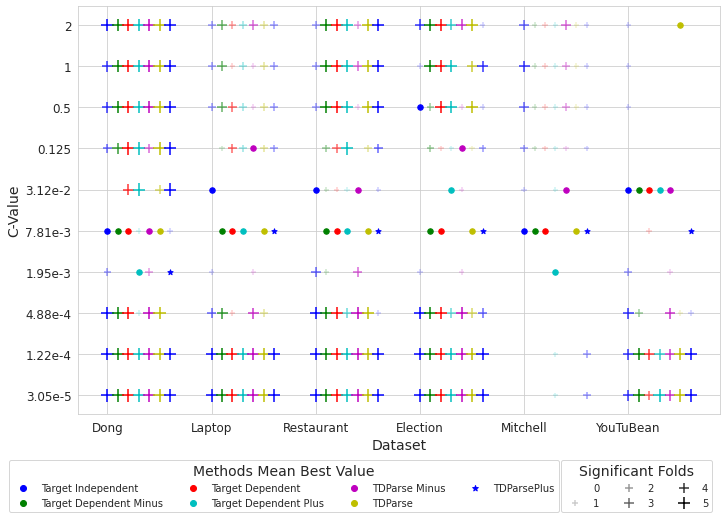

In [199]:
c_default_params = default_params(datasets, model_names)
c_params = [1] # include the default sklearn C Value
for c in range(-15, 3, 2):
    c_params.append(math.pow(2, c))
# This is for plotting the data
c_param_mapper = {2.0: '2', 1.0: '1', 0.5: '0.5', 0.125: '0.125', 
                  0.03125: '3.12e-2', 0.0078125: '7.81e-3', 
                  0.001953125: '1.95e-3', 0.00048828125: '4.88e-4',
                  0.0001220703125: '1.22e-4', 
                  3.0517578125e-05: '3.05e-5'}
c_values = cross_val_predictions(datasets, models, c_default_params, 
                                 c_value_dir, num_folds, 'C', c_params, 
                                 n_cpus)
ax = gen_plot_sig_data(c_value_dir, datasets, models, c_values, num_folds,
                       c_params, accuracy_score, 'Accuracy', c_param_mapper)
ax.figure.set_size_inches(11.5, 7.5)
ax.set_ylabel('C-Value')
ax.set_xlabel('Dataset')
#ax.set_title('Significant differences between the\nbest C value and the rest (Accuracy)')
image_c_dir = image_dir / 'C Value'
image_c_dir.mkdir(parents=True, exist_ok=True)
image_save_fp = image_c_dir / 'C_Sig_Plot_Accuracy.pdf'
ax.figure.savefig(str(image_save_fp.resolve()), bbox_inches='tight')


F1:

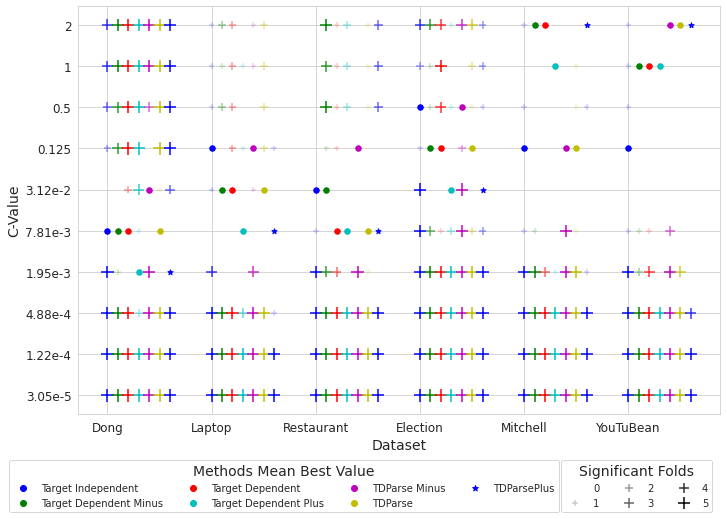

In [240]:
ax = gen_plot_sig_data(c_value_dir, datasets, models, c_values, num_folds,
                       c_params, f1_score, 'F1', c_param_mapper, average='macro')
ax.figure.set_size_inches(11.5, 7.5)
ax.set_ylabel('C-Value')
ax.set_xlabel('Dataset')
#ax.set_title('Significant differences between the\nbest C value and the rest (F1)')
image_save_fp = image_c_dir / 'C_Sig_Plot_F1.pdf'
ax.figure.savefig(str(image_save_fp.resolve()), bbox_inches='tight')

Below we also show the mean cross validation scores for each C Value for each dataset for each model. As you can see below they show a good refelection of the significance results above.

Accuracy:

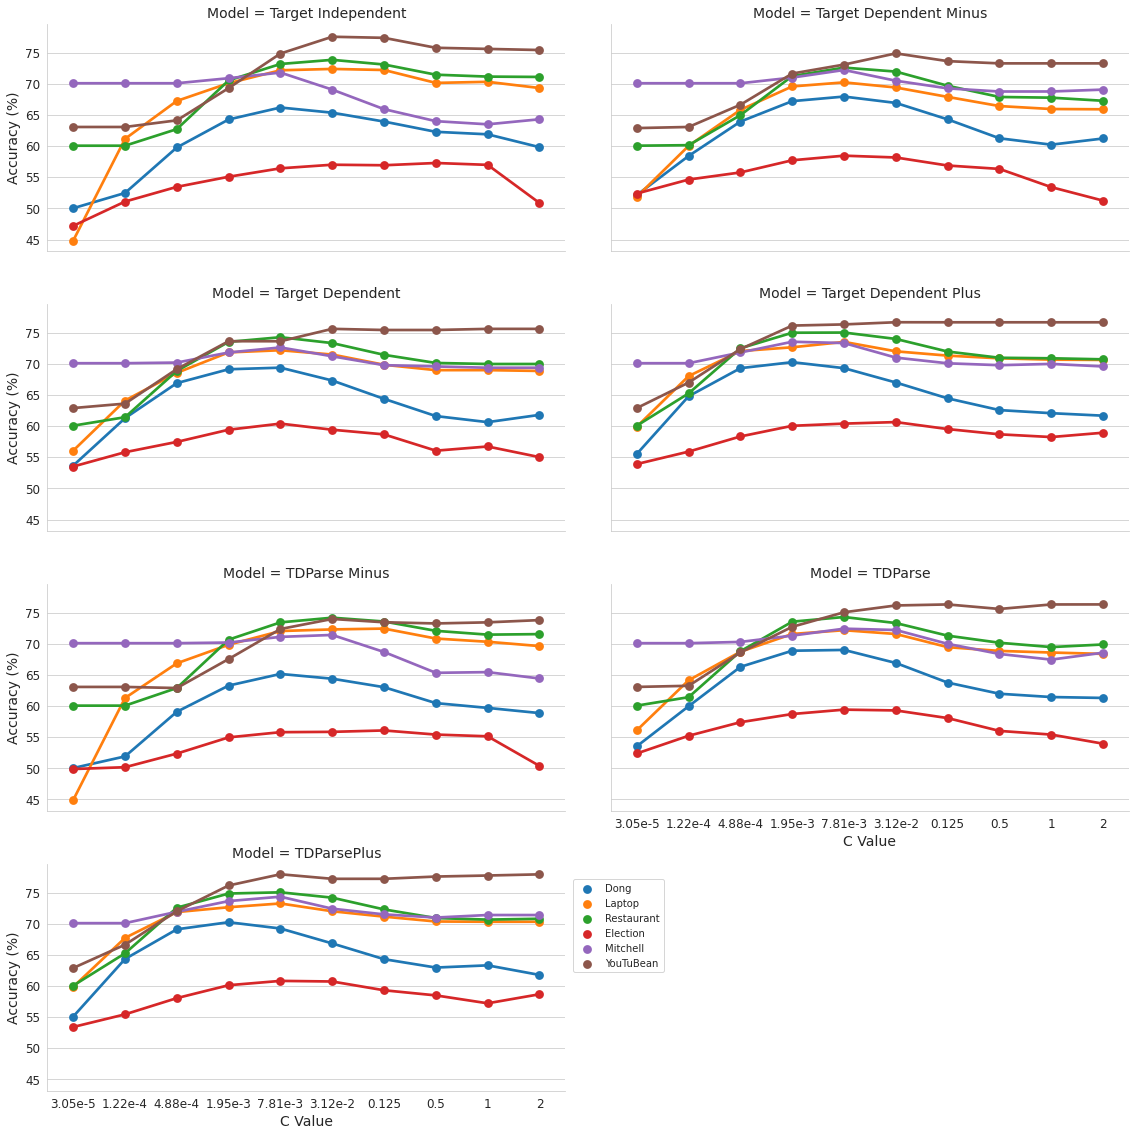

In [262]:
c_metric_scores = get_metric_scores(datasets, models, c_values, 
                                    num_folds, c_params, accuracy_score)
c_metric_scores['Score'] = c_metric_scores['Score'] * 100
ax = sns.factorplot(x="Parameter", y="Score", hue="Dataset", col="Model",
                    data=c_metric_scores, kind="point", size=4, ci=None,
                    aspect=2, col_wrap=2, legend=False)
param_names = [c_param_mapper[param_value] 
               for param_value in sorted(c_params)]
ax.set_xticklabels(param_names)
ax.set_ylabels('Accuracy (%)')
ax.set_xlabels('C Value')
plt.legend(loc='lower right',  bbox_to_anchor=(1.2, 0.5))
ax.savefig(str(image_c_dir / 'C_Accuracy_Plot.pdf'), bbox_inches='tight')

F1:

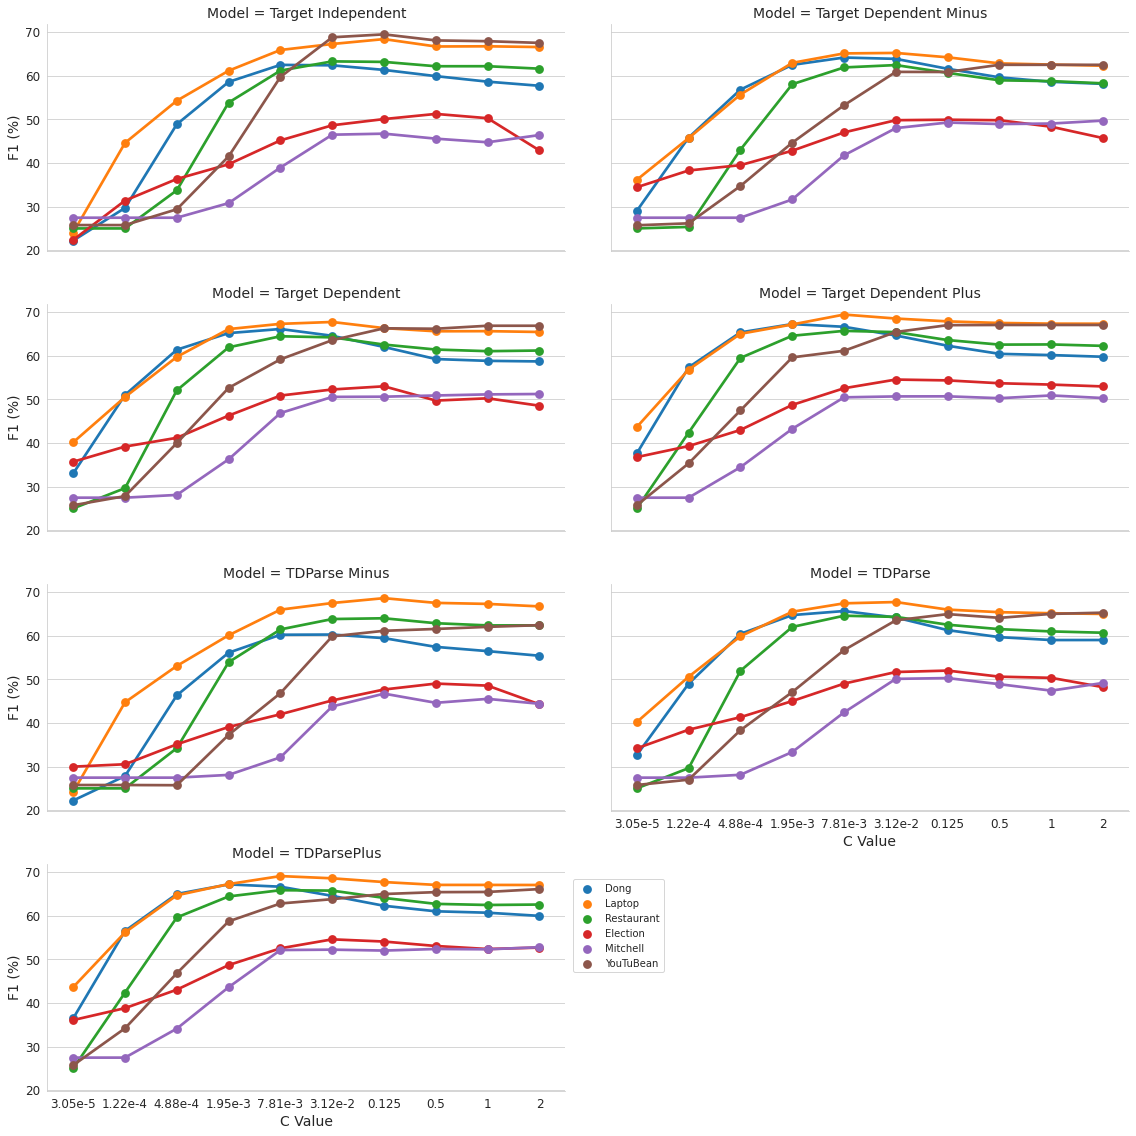

In [265]:
c_metric_scores = get_metric_scores(datasets, models, c_values, 
                                    num_folds, c_params, f1_score, average='macro')
c_metric_scores['Score'] = c_metric_scores['Score'] * 100
ax = sns.factorplot(x="Parameter", y="Score", hue="Dataset", col="Model",
                    data=c_metric_scores, kind="point", size=4, ci=None,
                    aspect=2, col_wrap=2, legend=False)
param_names = [c_param_mapper[param_value] 
               for param_value in sorted(c_params)]
ax.set_xticklabels(param_names)
ax.set_ylabels('F1 (%)')
ax.set_xlabels('C Value')
plt.legend(loc='lower right',  bbox_to_anchor=(1.2, 0.5))
ax.savefig(str(image_c_dir / 'C_F1_Plot.pdf'), bbox_inches='tight')

## The affect of Scaling

Accuracy:

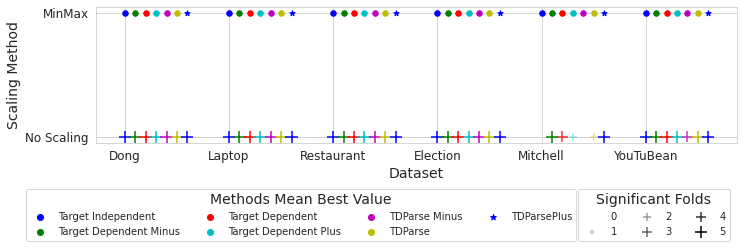

In [266]:
best_c_dict = best_param_index(datasets, models, num_folds, c_values, accuracy_score)
optimal_c_params = get_specific_params([best_c_dict], ['C'], [c_params])
scaling_default_params = default_params(datasets, model_names, optimal_c_params)

scaling_params = [None, MinMaxScaler()]
scaling_values = cross_val_predictions(datasets, models, scaling_default_params, 
                                       scaling_dir, num_folds, 'scale', scaling_params, 
                                       n_cpus)
image_scaling_dir = image_dir / 'Scaling'
image_scaling_dir.mkdir(parents=True, exist_ok=True)

scaling_mapper = {MinMaxScaler(): 'MinMax', None: 'No Scaling', np.nan: 'No Scaling'}
ax = gen_plot_sig_data(scaling_dir, datasets, models, scaling_values, num_folds,
                       scaling_params, accuracy_score, 'Accuracy', scaling_mapper,
                       legend_height=-0.3)
ax.figure.set_size_inches(11.5, 2.5)
ax.set_ylabel('Scaling Method')
ax.set_xlabel('Dataset')
#ax.set_title('Significant differences between Using\nMinMax scaling and no scaling (Accuracy)')
ax.figure.savefig(str(Path(image_scaling_dir, 'Scaling_Sig_Plot_Accuracy.pdf').resolve()), bbox_inches='tight')

F1:

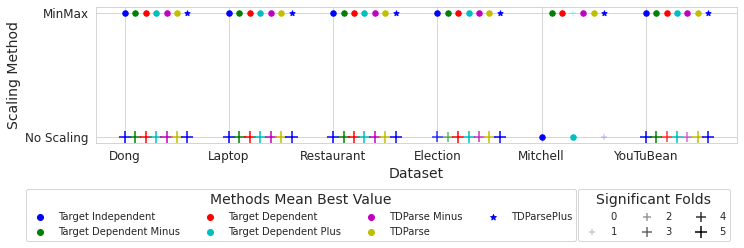

In [245]:
ax = gen_plot_sig_data(scaling_dir, datasets, models, scaling_values, num_folds,
                       scaling_params, f1_score, 'F1', scaling_mapper, average='macro',
                       legend_height=-0.3)
ax.figure.set_size_inches(11.5, 2.5)
ax.set_ylabel('Scaling Method')
ax.set_xlabel('Dataset')
#ax.set_title('Significant differences between Using\nMinMax scaling and no scaling (F1)')
ax.figure.savefig(str(Path(image_scaling_dir, 'Scaling_Sig_Plot_F1.pdf').resolve()), bbox_inches='tight')

Accuracy:

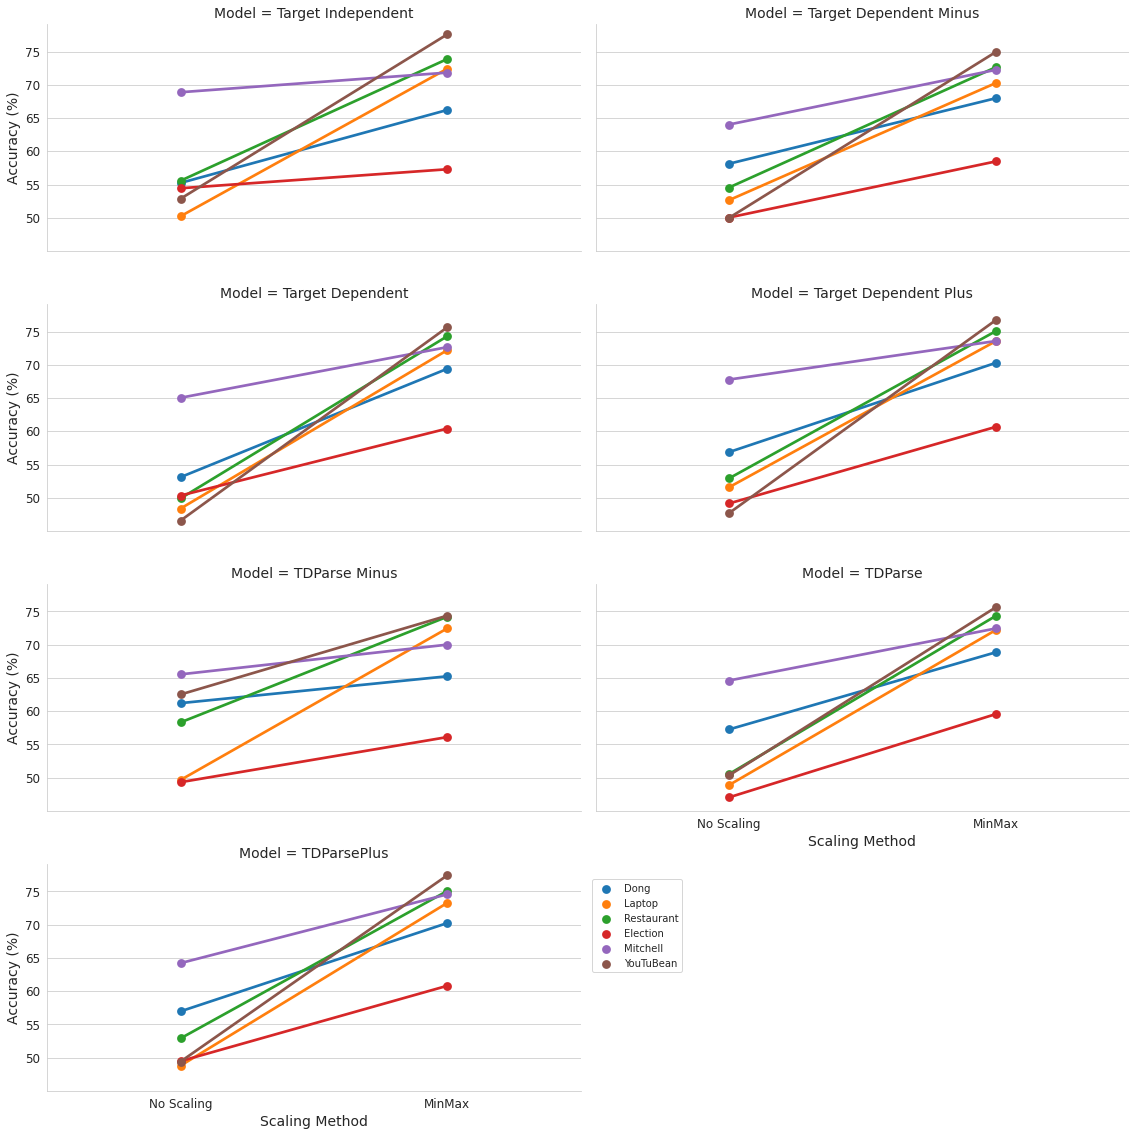

In [269]:
scaling_mapper_alt = {str(key): value for key, value in scaling_mapper.items()}
scaling_metric_scores = get_metric_scores(datasets, models, scaling_values, 
                                          num_folds, scaling_params, accuracy_score)
scaling_metric_scores['Score'] = scaling_metric_scores['Score'] * 100
scaling_metric_scores['Parameter'] = scaling_metric_scores['Parameter'].apply(lambda x: scaling_mapper_alt[str(x)])
ax = sns.factorplot(x="Parameter", y="Score", hue="Dataset", col="Model",
                    data=scaling_metric_scores, kind="point", size=4, ci=None,
                    aspect=2, col_wrap=2, legend=False)
ax.set_ylabels('Accuracy (%)')
ax.set_xlabels('Scaling Method')
plt.legend(loc='lower right',  bbox_to_anchor=(1.2, 0.5))
ax.savefig(str(Path(image_scaling_dir, 'Scaling_Accuracy_Plot.pdf').resolve()), bbox_inches='tight')

F1:

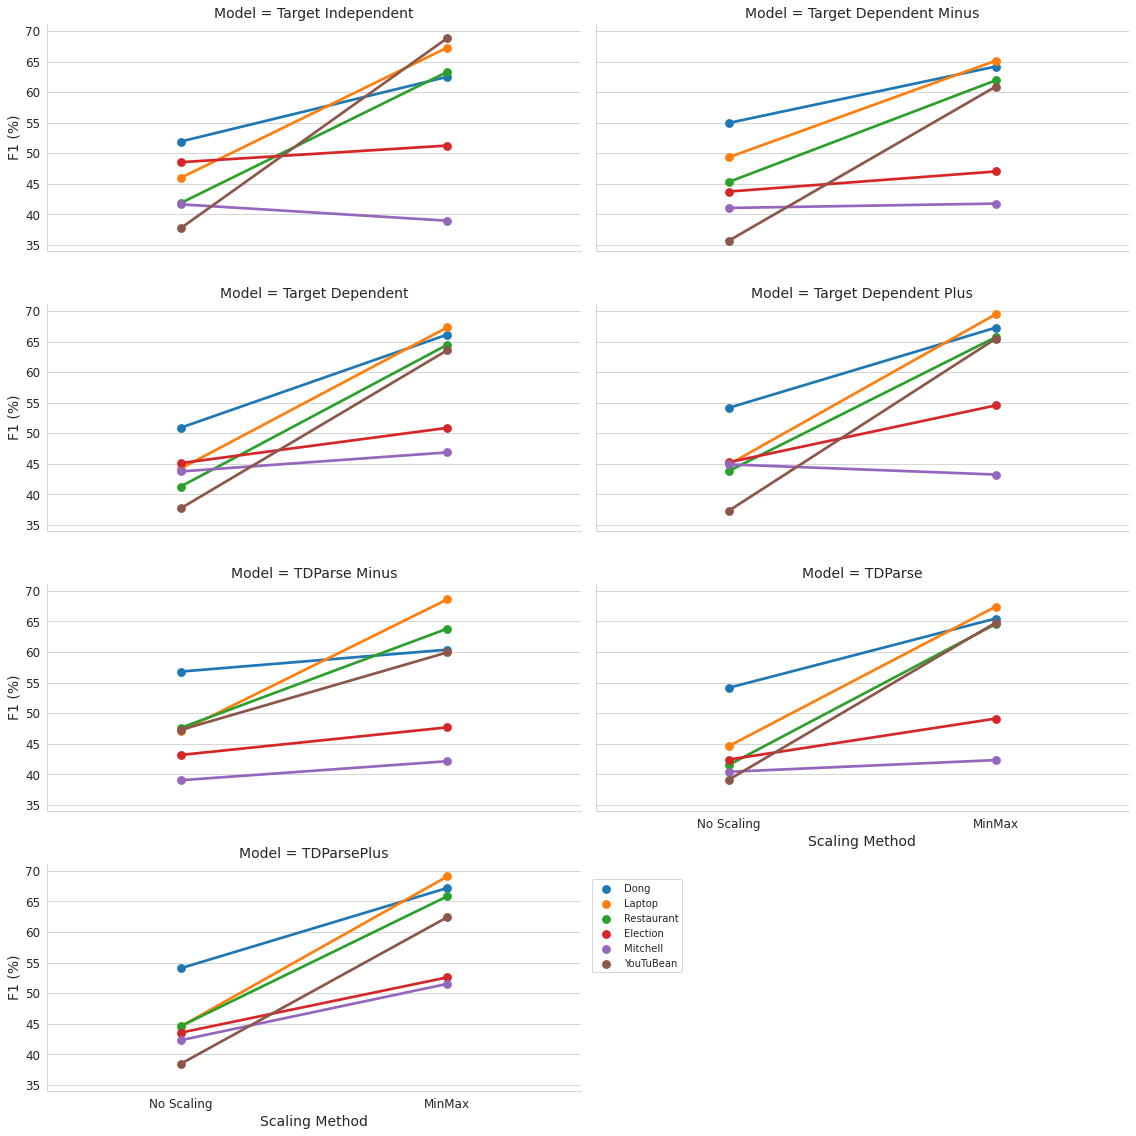

In [272]:
scaling_mapper_alt = {str(key): value for key, value in scaling_mapper.items()}
scaling_metric_scores = get_metric_scores(datasets, models, scaling_values, 
                                          num_folds, scaling_params, f1_score, average='macro')
scaling_metric_scores['Score'] = scaling_metric_scores['Score'] * 100
scaling_metric_scores['Parameter'] = scaling_metric_scores['Parameter'].apply(lambda x: scaling_mapper_alt[str(x)])
ax = sns.factorplot(x="Parameter", y="Score", hue="Dataset", col="Model",
                    data=scaling_metric_scores, kind="point", size=4, ci=None,
                    aspect=2, col_wrap=2, legend=False)
ax.set_ylabels('F1 (%)')
ax.set_xlabels('Scaling Method')
plt.legend(loc='lower right',  bbox_to_anchor=(1.2, 0.5))
ax.savefig(str(Path(image_scaling_dir, 'Scaling_F1_Plot.pdf').resolve()), bbox_inches='tight')